<a href="https://colab.research.google.com/github/giovanirojascuela/2025_5TO01/blob/main/TALLER/EVALUACION/LOPEZ_LAYME_BRENDA_SHIAMIRA_PRATE01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Predicción de Ventas de Café con TensorFlow Keras**:

In [ ]:
# Instalar librerías necesarias (ejecutar solo si no están instaladas)
!pip install --quiet pandas numpy matplotlib seaborn scikit-learn tensorflow joblib


###-Instalación e importación de librerías

In [ ]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import joblib  # Para guardar y cargar objetos preprocesadores


In [ ]:
# Subir archivos index_1.csv y index_2.csv usando el panel lateral de Colab o:
from google.colab import files
uploaded = files.upload()


Saving index_1.csv to index_1 (1).csv
Saving index_2.csv to index_2 (1).csv


#1. Análisis y Preparación de Datos

In [ ]:
# Cargar datasets con separador comma
df1 = pd.read_csv('index_1.csv', sep=',')
df2 = pd.read_csv('index_2.csv', sep=',')

# Unir datasets (concatenar filas)
df = pd.concat([df1, df2], ignore_index=True)

print(f"Dataset combinado: {df.shape[0]} filas, {df.shape[1]} columnas")
df.head()

Dataset combinado: 3898 filas, 6 columnas


,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


##-Análisis Exploratorio de Datos (EDA)

In [ ]:
print("Información general del dataset:")
print(df.info())

print("\nValores nulos por columna:")
print(df.isnull().sum())


Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3898 entries, 0 to 3897
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3898 non-null   object 
 1   datetime     3898 non-null   object 
 2   cash_type    3898 non-null   object 
 3   card         3547 non-null   object 
 4   money        3898 non-null   float64
 5   coffee_name  3898 non-null   object 
dtypes: float64(1), object(5)
memory usage: 182.8+ KB
None

Valores nulos por columna:
date             0
datetime         0
cash_type        0
card           351
money            0
coffee_name      0
dtype: int64


In [ ]:
print("Estadísticas descriptivas de las columnas numéricas:")
print(df.describe())


Estadísticas descriptivas de las columnas numéricas:
            money
count  3898.00000
mean     31.38060
std       5.06461
min      15.00000
25%      27.92000
50%      32.82000
75%      35.76000
max      40.00000


In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'], format='mixed', errors='coerce')
print("Conversion a datetime exitosa.")

Conversion a datetime exitosa.


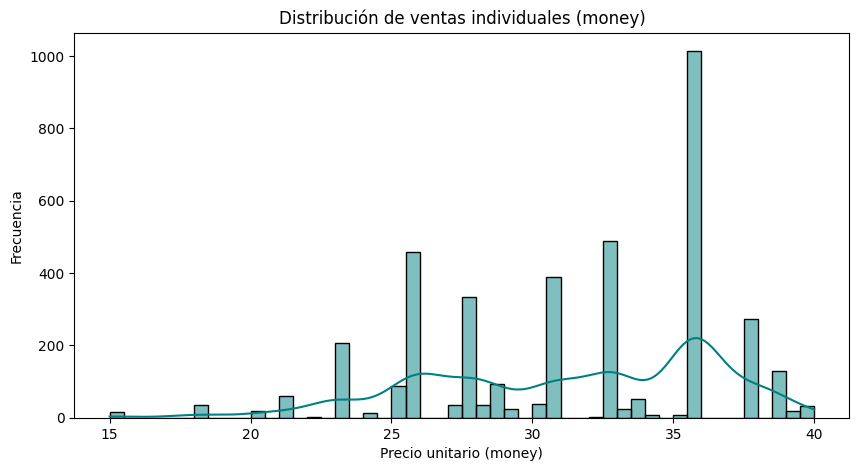

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df['money'], bins=50, kde=True, color='teal')
plt.title("Distribución de ventas individuales (money)")
plt.xlabel("Precio unitario (money)")
plt.ylabel("Frecuencia")
plt.show()


/tmp/ipython-input-39-559127556.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='coffee_name', order=order, palette='viridis')


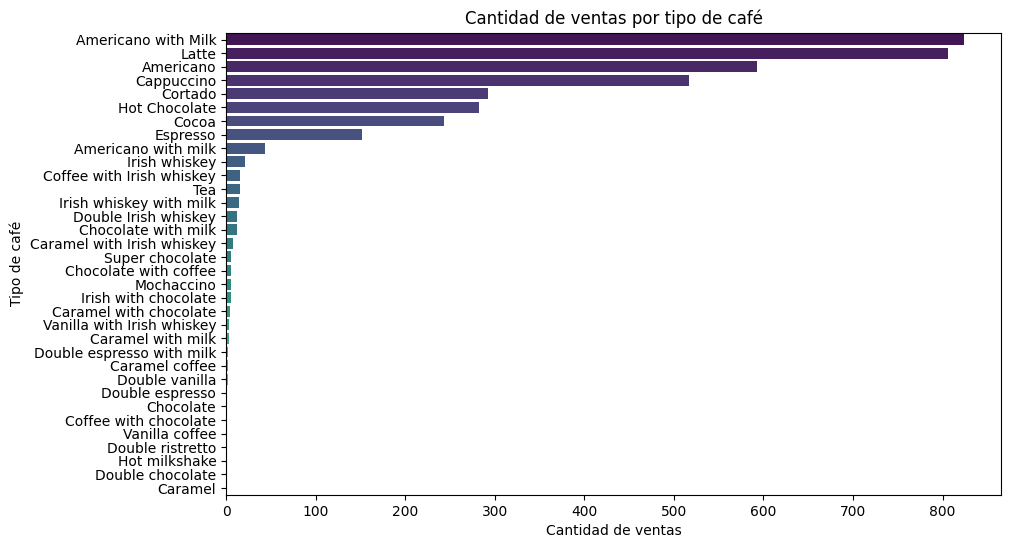

In [ ]:

plt.figure(figsize=(10,6))
order = df['coffee_name'].value_counts().index
sns.countplot(data=df, y='coffee_name', order=order, palette='viridis')
plt.title("Cantidad de ventas por tipo de café")
plt.xlabel("Cantidad de ventas")
plt.ylabel("Tipo de café")
plt.show()



##-Ingeniería de Características

In [ ]:
df['mes'] = df['datetime'].dt.month
df['dia_semana'] = df['datetime'].dt.dayofweek  # lunes=0, domingo=6
df['hora'] = df['datetime'].dt.hour

print("Características temporales añadidas:")
df[['datetime', 'mes', 'dia_semana', 'hora']].head()


Características temporales añadidas:


,datetime,mes,dia_semana,hora
0,2024-03-01 10:15:50.520,3,4,10
1,2024-03-01 12:19:22.539,3,4,12
2,2024-03-01 12:20:18.089,3,4,12
3,2024-03-01 13:46:33.006,3,4,13
4,2024-03-01 13:48:14.626,3,4,13


In [ ]:
ventas_dia = df.groupby('date')['money'].sum().reset_index()
ventas_dia.rename(columns={'money':'cantidad_total_vendida_no_dia'}, inplace=True)

print("Ventas totales diarias (primeras filas):")
display(ventas_dia.head())


Ventas totales diarias (primeras filas):


,date,cantidad_total_vendida_no_dia
0,2024-03-01,396.3
1,2024-03-02,228.1
2,2024-03-03,349.1
3,2024-03-04,135.2
4,2024-03-05,338.5


##-Codificación de variables categóricas

In [ ]:
from sklearn.preprocessing import OneHotEncoder

categorical_vars = ['cash_type', 'coffee_name']

encoder = OneHotEncoder(handle_unknown='ignore')
encoded = encoder.fit_transform(df[categorical_vars])

encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical_vars))

# Concatenar con df original
df_encoded = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)
df_encoded.drop(columns=categorical_vars, inplace=True)

print("Variables categóricas codificadas con OneHotEncoder:")
df_encoded.head()

Variables categóricas codificadas con OneHotEncoder:


,date,datetime,card,money,mes,dia_semana,hora,cash_type_card,cash_type_cash,coffee_name_Americano,...,coffee_name_Hot milkshake,coffee_name_Irish whiskey,coffee_name_Irish whiskey with milk,coffee_name_Irish with chocolate,coffee_name_Latte,coffee_name_Mochaccino,coffee_name_Super chocolate,coffee_name_Tea,coffee_name_Vanilla coffee,coffee_name_Vanilla with Irish whiskey
0,2024-03-01,2024-03-01 10:15:50.520,ANON-0000-0000-0001,38.7,3,4,10,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2024-03-01,2024-03-01 12:19:22.539,ANON-0000-0000-0002,38.7,3,4,12,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2024-03-01,2024-03-01 12:20:18.089,ANON-0000-0000-0002,38.7,3,4,12,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2024-03-01,2024-03-01 13:46:33.006,ANON-0000-0000-0003,28.9,3,4,13,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2024-03-01,2024-03-01 13:48:14.626,ANON-0000-0000-0004,38.7,3,4,13,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


##-División de datos para Modelo 1 (ventas totales diarias)

In [ ]:
# Features para Modelo 1: mes y día de la semana
X = pd.DataFrame()
X['mes'] = pd.to_datetime(ventas_dia['date']).dt.month
X['dia_semana'] = pd.to_datetime(ventas_dia['date']).dt.dayofweek

# Target
y = ventas_dia['cantidad_total_vendida_no_dia']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Entrenamiento: {X_train.shape[0]} filas, Prueba: {X_test.shape[0]} filas")


Entrenamiento: 304 filas, Prueba: 77 filas


##-Escalado para Modelo 1

In [ ]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))

print("Escalado completado para X e y.")


Escalado completado para X e y.


#2. Modelado Predictivo (con TensorFlow Keras)
###            Modelo 1 — Predicción de ventas totales diarias

In [ ]:
# 9.1 Importar callback necesario
from tensorflow.keras.callbacks import EarlyStopping

# 9.2 Definir la arquitectura del modelo
model_total = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # más neuronas
    Dropout(0.3),                                                            # mayor dropout para regularización
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # salida de regresión
])

# 9.3 Compilar el modelo
model_total.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# 9.4 Configurar EarlyStopping para evitar overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,           # detiene si no mejora en 10 épocas
    restore_best_weights=True
)

# 9.5 Entrenar el modelo
history = model_total.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=100,            # más épocas para permitir parada temprana
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)



Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.0923 - mae: 0.7960 - val_loss: 0.7922 - val_mae: 0.7226
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0207 - mae: 0.7561 - val_loss: 0.8097 - val_mae: 0.7258
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1877 - mae: 0.8617 - val_loss: 0.8134 - val_mae: 0.7435
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9865 - mae: 0.7837 - val_loss: 0.8258 - val_mae: 0.7450
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0206 - mae: 0.7818 - val_loss: 0.8355 - val_mae: 0.7482
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0489 - mae: 0.7968 - val_loss: 0.8325 - val_mae: 0.7514
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9276 - mae: 0.7485 - val_loss: 0.8213 - val_mae: 0.7432
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9446 - mae: 0.7558 - val_loss: 0.8128 - val_mae: 0.7355
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0917 - mae: 0.

In [ ]:
# 10.1.1 Generar predicciones escaladas
y_pred_scaled = model_total.predict(X_test_scaled)

# 10.1.2 Desescalar predicciones
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# 10.1.3 Recuperar valores reales sin escalar
y_true = y_test.values.reshape(-1, 1)




3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
MAE: 144.15
MSE: 33964.98
RMSE: 184.30
R²: 0.04


In [ ]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("📊 Evaluación Modelo 1: Ventas Totales Diarias")
print(f"• MAE:  {mae:.2f}")
print(f"• MSE:  {mse:.2f}")
print(f"• RMSE: {rmse:.2f}")
print(f"• R²:   {r2:.2f}")





📊 Evaluación Modelo 1: Ventas Totales Diarias
• MAE:  144.15
• MSE:  33964.98
• RMSE: 184.30
• R²:   0.04


In [ ]:
import pandas as pd

comparacion = pd.DataFrame({
    'Ventas Reales':    y_true.flatten(),
    'Ventas Predichas': y_pred.flatten()
}).head(10)

print("\n— Comparación (10 primeras observaciones) —")
display(comparacion)



— Comparación (10 primeras observaciones) —


,Ventas Reales,Ventas Predichas
0,373.76,339.438080
1,310.54,317.451141
2,276.50,339.111115
3,121.48,328.525360
4,37.72,309.161713
5,186.10,339.111115
6,348.26,326.996002
7,685.02,324.781006
8,427.14,336.367706
9,385.52,323.532013


/tmp/ipython-input-51-321839507.py:19: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


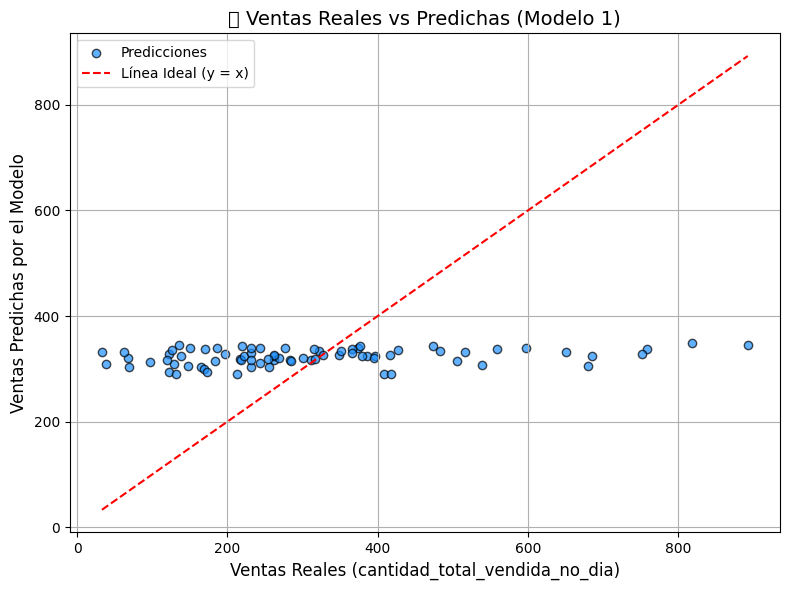

In [ ]:
# Aseguramos que y_true y y_pred estén en formato 1D para graficar correctamente
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# Crear el gráfico de dispersión
plt.figure(figsize=(8,6))
plt.scatter(y_true_flat, y_pred_flat, alpha=0.7, color='dodgerblue', edgecolors='k', label='Predicciones')
plt.plot([min(y_true_flat), max(y_true_flat)],
         [min(y_true_flat), max(y_true_flat)],
         'r--',
         label='Línea Ideal (y = x)')

# Etiquetas y estética
plt.title("🧠 Ventas Reales vs Predichas (Modelo 1)", fontsize=14)
plt.xlabel("Ventas Reales (cantidad_total_vendida_no_dia)", fontsize=12)
plt.ylabel("Ventas Predichas por el Modelo", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##-Preparar datos para Modelo 2 (ventas por tipo de café)

In [ ]:
ventas_tipo_cafe = df.groupby(['date', 'coffee_name'])['money'].sum().reset_index()
ventas_tipo_cafe.rename(columns={'money':'cantidad_vendida'}, inplace=True)

ventas_tipo_cafe['date'] = pd.to_datetime(ventas_tipo_cafe['date'])
ventas_tipo_cafe['mes'] = ventas_tipo_cafe['date'].dt.month
ventas_tipo_cafe['dia_semana'] = ventas_tipo_cafe['date'].dt.dayofweek

encoder_coffee = OneHotEncoder(handle_unknown='ignore')
coffee_encoded = encoder_coffee.fit_transform(ventas_tipo_cafe[['coffee_name']])
coffee_encoded_df = pd.DataFrame(coffee_encoded.toarray(), columns=encoder_coffee.get_feature_names_out(['coffee_name']))

X2 = pd.concat([ventas_tipo_cafe[['mes', 'dia_semana']].reset_index(drop=True), coffee_encoded_df], axis=1)
y2 = ventas_tipo_cafe['cantidad_vendida']

print("Datos para Modelo 2 (primeras filas):")
display(X2.head())
display(y2.head())

Datos para Modelo 2 (primeras filas):


,mes,dia_semana,coffee_name_Americano,coffee_name_Americano with Milk,coffee_name_Americano with milk,coffee_name_Cappuccino,coffee_name_Caramel,coffee_name_Caramel coffee,coffee_name_Caramel with Irish whiskey,coffee_name_Caramel with chocolate,...,coffee_name_Hot milkshake,coffee_name_Irish whiskey,coffee_name_Irish whiskey with milk,coffee_name_Irish with chocolate,coffee_name_Latte,coffee_name_Mochaccino,coffee_name_Super chocolate,coffee_name_Tea,coffee_name_Vanilla coffee,coffee_name_Vanilla with Irish whiskey
0,3,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


,cantidad_vendida
0,28.9
1,135.2
2,38.7
3,116.1
4,77.4


In [ ]:
# Agrupar datos por fecha y tipo de café
ventas_tipo = df.groupby(['date', 'coffee_name'])['money'].sum().reset_index()
ventas_tipo.rename(columns={'money': 'cantidad_vendida'}, inplace=True)

# Convertir a datetime y extraer características temporales
ventas_tipo['date'] = pd.to_datetime(ventas_tipo['date'])
ventas_tipo['mes'] = ventas_tipo['date'].dt.month
ventas_tipo['dia_semana'] = ventas_tipo['date'].dt.dayofweek

# One-Hot Encoding del tipo de café
encoder_cafe = OneHotEncoder(handle_unknown='ignore')
cafe_encoded = encoder_cafe.fit_transform(ventas_tipo[['coffee_name']])
df_cafe_encoded = pd.DataFrame(cafe_encoded.toarray(), columns=encoder_cafe.get_feature_names_out(['coffee_name']))

# Concatenar las variables numéricas y categóricas codificadas
X2 = pd.concat([ventas_tipo[['mes', 'dia_semana']].reset_index(drop=True), df_cafe_encoded], axis=1)
y2 = ventas_tipo['cantidad_vendida']

In [ ]:
# Dividir en conjunto de entrenamiento y prueba
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Escalar entradas (X)
scaler_X2 = StandardScaler()
X2_train_scaled = scaler_X2.fit_transform(X2_train)
X2_test_scaled = scaler_X2.transform(X2_test)

# Escalar salidas (y)
scaler_y2 = StandardScaler()
y2_train_scaled = scaler_y2.fit_transform(y2_train.values.reshape(-1,1))
y2_test_scaled = scaler_y2.transform(y2_test.values.reshape(-1,1))


In [ ]:
# Crear modelo secuencial
model_tipo = Sequential([
    Dense(128, activation='relu', input_shape=(X2_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compilar modelo
model_tipo.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callback para parada temprana
early_stop2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history2 = model_tipo.fit(
    X2_train_scaled, y2_train_scaled,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop2],
    verbose=1
)


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.2477 - mae: 0.8266 - val_loss: 0.9509 - val_mae: 0.6969
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0238 - mae: 0.7072 - val_loss: 0.9230 - val_mae: 0.7022
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9372 - mae: 0.7175 - val_loss: 0.8875 - val_mae: 0.6930
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9619 - mae: 0.7312 - val_loss: 0.9050 - val_mae: 0.6806
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8713 - mae: 0.6891 - val_loss: 0.8771 - val_mae: 0.6762
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9118 - mae: 0.6857 - val_loss: 0.8571 - val_mae: 0.6763
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8720 - mae: 0.6902 - val_loss: 0.8778 - val_mae: 0.6729
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9617 - mae: 0.7132 - val_loss: 0.8719 - val_mae: 0.6782
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.8

In [ ]:
# Predecir y desescalar
y2_pred_scaled = model_tipo.predict(X2_test_scaled)
y2_pred = scaler_y2.inverse_transform(y2_pred_scaled)
y2_true = y2_test.values.reshape(-1, 1)

# Mostrar métricas
print("📊 Evaluación Modelo 2 - Ventas por Tipo de Café")
print(f"• MAE:  {mean_absolute_error(y2_true, y2_pred):.2f}")
print(f"• MSE:  {mean_squared_error(y2_true, y2_pred):.2f}")
print(f"• RMSE: {np.sqrt(mean_squared_error(y2_true, y2_pred)):.2f}")
print(f"• R²:   {r2_score(y2_true, y2_pred):.2f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
📊 Evaluación Modelo 2 - Ventas por Tipo de Café
• MAE:  31.62
• MSE:  1638.36
• RMSE: 40.48
• R²:   0.18


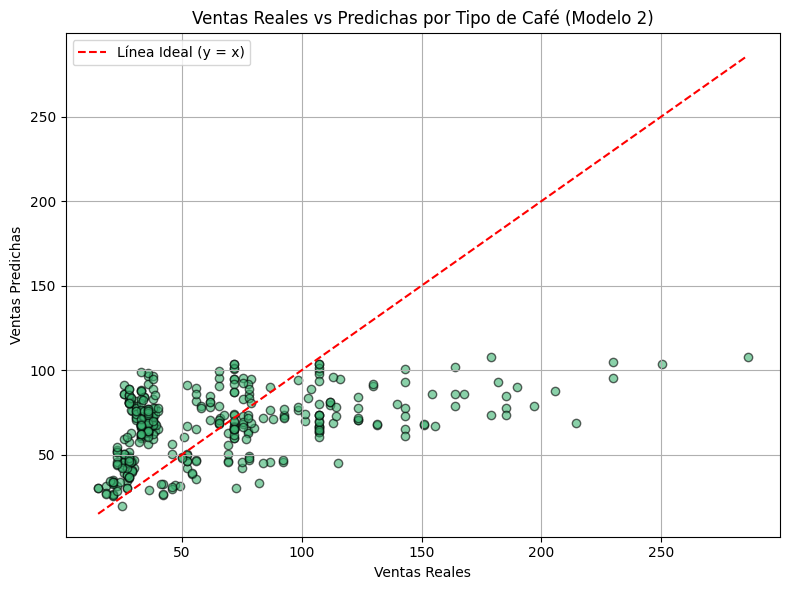

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y2_true.flatten(), y2_pred.flatten(), alpha=0.6, color='mediumseagreen', edgecolors='k')
plt.plot([y2_true.min(), y2_true.max()], [y2_true.min(), y2_true.max()], 'r--', label='Línea Ideal (y = x)')
plt.title("Ventas Reales vs Predichas por Tipo de Café (Modelo 2)")
plt.xlabel("Ventas Reales")
plt.ylabel("Ventas Predichas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#3.Serialización de modelos y preprocesadores



In [ ]:
# Guardar modelos de Keras en formato SavedModel con extensión .keras
model_total.save('modelo_ventas_totales.keras')
model_tipo.save('modelo_ventas_tipo_cafe.keras')

# Guardar preprocesadores con joblib
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')
joblib.dump(scaler_X2, 'scaler_X2.pkl')
joblib.dump(scaler_y2, 'scaler_y2.pkl')
joblib.dump(encoder_cafe, 'encoder_cafe.pkl')

print(" Modelos y preprocesadores guardados correctamente.")

 Modelos y preprocesadores guardados correctamente.


In [ ]:
from tensorflow.keras.models import load_model
modelo_cargado = load_model('modelo_ventas_totales.keras')
print("Modelo cargado correctamente.")

Modelo cargado correctamente.
